# Using BGLS with MPS to solve QAOA problems

For large sparse graphs, we expect matrix product states to be particularly efficient being that their runtime scales primarily in the (sparse) degree of connectedness. Here we will use such states with our bgls sampler to solve the MaxCut problem for random graphs.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import sympy

import networkx as nx

import cirq
import cirq.contrib.quimb as ccq
import cirq.contrib.quimb.mps_simulator
from cirq.contrib.svg import SVGCircuit

import quimb.tensor as qtn

import bgls


ModuleNotFoundError: No module named 'quimb'

Here we define a function to compute bitstring amplitudes for a matrix product state.

In [ ]:
def cirq_mps_bitstring_probability(
        mps: cirq.contrib.quimb.MPSState, bitstring: str
) -> float:
    """
    Returns the probability of measuring the `bitstring` (|z⟩) in the
    'cirq.contrib.quimb.MPSState' mps.
    Args:
        mps: Matrix Product State as a 'cirq.contrib.quimb.MPSState'.
        bitstring: Bitstring |z⟩ as a binary string.
    """
    M_subset = []
    for i, Ai in enumerate(mps.M):
        qubit_index = mps.i_str(i)
        # selecting the component with matching bitstring:
        A_subset = Ai.isel({qubit_index: int(bitstring[i])})
        M_subset.append(A_subset)

    tensor_network = qtn.TensorNetwork(M_subset)
    bitstring_amplitude = tensor_network.contract(inplace=False)
    return np.power(np.abs(bitstring_amplitude), 2)

We first create a random graph with n nodes and connectivity p

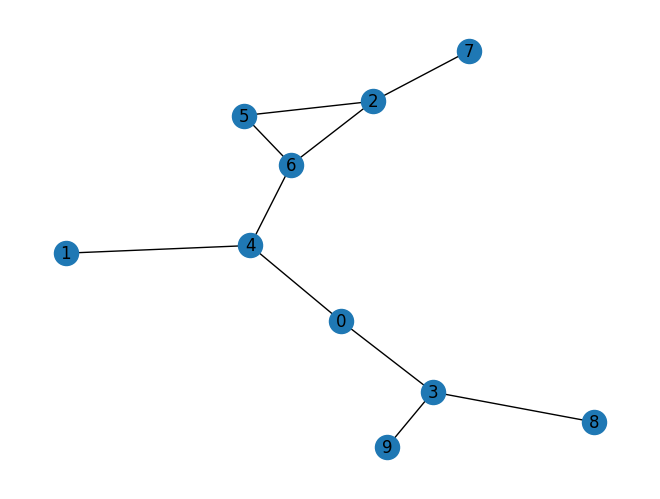

In [126]:
n = 10
p = 0.3
rand_graph = nx.erdos_renyi_graph(n, p, seed=2)
nx.draw(rand_graph, with_labels=True)

We then implement the cost hamiltonian translated to qubits $H_c = \frac{1}{2}\sum(1-Z_iZ_j)$, parametrized as $U_c=e^{i\gamma H_c}$, as well as the mixing hamiltonian $H_m = \sum X_i$, parametrized as $U_m=e^{i\beta H_m}$.

In [28]:
def config_energy(assignments, graph):
    energy = 0.
    for (i, j) in graph.edges:
        energy += 1 - (assignments[i] * assignments[j])
    energy /= 2
    return energy


def obj_func(result, graph):
    # return the average energy for a results repetitions
    def config_energy(assignments):
        energy = 0.
        for (i, j) in graph.edges:
            energy += 1 - (assignments[i] * assignments[j])
        energy /= 2
        return energy

    assignments = 2 * result.measurements.get("z") - 1  # convert to +- 1
    return np.average(
        [config_energy(assignment) for assignment in assignments])


def Uc(graph, gamma):
    for (i, j) in graph.edges:
        yield cirq.ZZ.on(cirq.LineQubit(i), cirq.LineQubit(j)) ** gamma


def Um(graph, beta):
    for i in graph.nodes:
        yield cirq.X.on(cirq.LineQubit(i)) ** beta


def construct_circuit(graph, p_range, gammas, betas):
    circuit = cirq.Circuit()
    for i in graph.nodes:
        circuit.append(cirq.H.on(cirq.LineQubit(i)))
    for p in range(p_range):
        circuit.append(Uc(graph, gammas[p]))
        circuit.append(Um(graph, betas[p]))
    circuit.append(
        cirq.measure(cirq.LineQubit.range(len(graph.nodes)), key='z'))
    return circuit


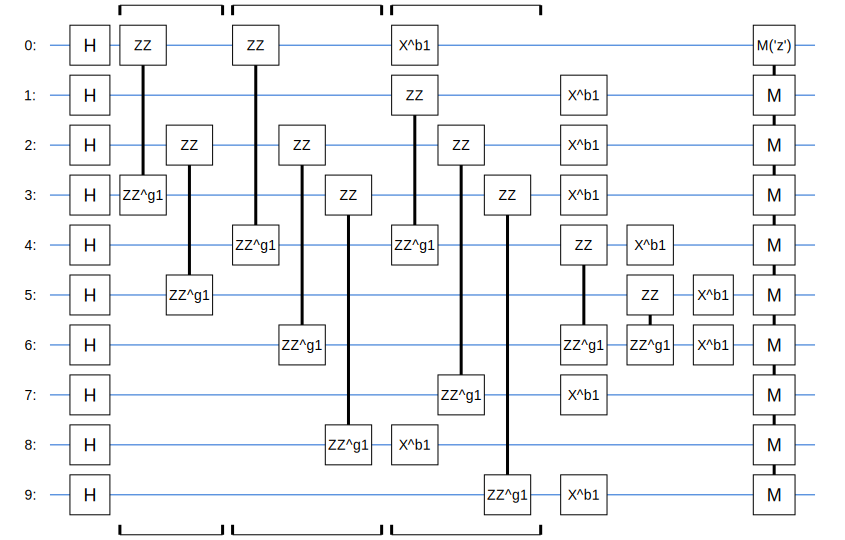

In [128]:
g1 = sympy.Symbol("g1")
b1 = sympy.Symbol("b1")

maxcut_circuit = construct_circuit(rand_graph, 1, [g1], [b1])
SVGCircuit(maxcut_circuit)


We find the optimal values of gamma and beta by sweeping across parameter combinations. Sampling repeatedly from the resultant circuits, and computing the final average energy for each, we pick the combination minimizing the energy. We can make use of symbols to call cirq's ```run_sweep``` across a range of settings.

In [30]:
ngammas = 8
nbetas = 8
param_sweep = (cirq.Linspace(key='g1', start=0.1, stop=0.9,
                             length=ngammas) * cirq.Linspace(key='b1',
                                                             start=0.1,
                                                             stop=0.9,
                                                             length=nbetas))


class LowChi(cirq.contrib.quimb.MPSOptions):
    max_bond = 3


bgls_mps_sampler = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=maxcut_circuit.all_qubits(), initial_state=0,
        prng=np.random.RandomState(), simulation_options=LowChi()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    seed=1
)


In [31]:
results = bgls_mps_sampler.run_sweep(maxcut_circuit, params=param_sweep,
                                     repetitions=100)

We then find the combo with minimum energy by searching over all pairs

In [32]:
energies = np.zeros(shape=(ngammas, nbetas))
max_energy = None
max_params = None
for i, result in enumerate(results):
    energy = obj_func(result, rand_graph)
    energies[int(i / ngammas), i % nbetas] = energy
    if max_energy == None or energy > max_energy:
        max_energy = energy
        max_params = result.params


Text(0.5, 1.0, 'energy')

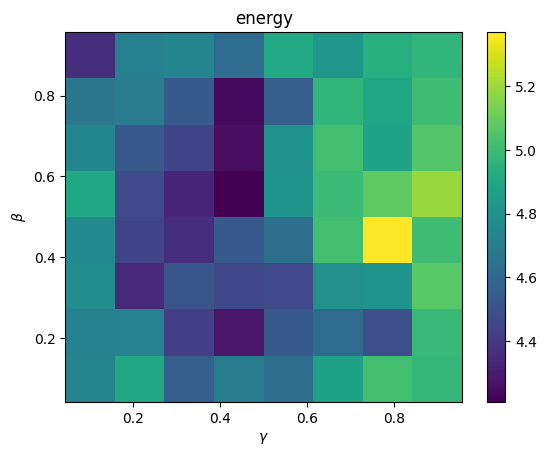

In [129]:
plt.pcolormesh(np.linspace(0.1, 0.9, ngammas), np.linspace(0.1, 0.9, nbetas),
               energies, shading="nearest")
plt.colorbar()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$");
plt.title("energy")

In [34]:
print("max energy: ", max_energy)
print("at params: ", max_params)

max energy:  5.37
at params:  cirq.ParamResolver({'g1': 0.44285714285714284, 'b1': 0.7857142857142856})


Finally we fix the maximized parameters, repeatedly sample at this configuration, and then take as our graph solution the measurement with maximal energy.

In [35]:
result_at_max = bgls_mps_sampler.run_sweep(maxcut_circuit, params=max_params,
                                           repetitions=1000)
result_at_max

[z=1100000000000100111110101001111101000110111011100010010100001001010000001000000011101100101100110001100001000100100001101101100101001100100100011101010011101111111000010111110011011000010100110010100110001111110001111101101101000000001111100101110101000001011101000010001000011110000001111001110100101101110000111010000100110111111111001101101110000101011000011011110110000001111111010011010100100010100101011000001111010101010101000000101001101001110011000000110011010101100010000000111011101101110110111001000111110000101101101111110100100011111101110111010000001011010110101001111011011001001001100100110011110101100010000000011000100111110010000110010101100010100111010011101010001010010010001010111100111000100010110011010100101011000110010000110101111110110011010011100110001001000011100110110110011100101011000100000010110111111001001010100101100100011011110010101101100001100100100110111011000000100010010100011111101000100111000101100011010100011000111110101100111001011110111010110000100

In [36]:
best_energies = np.zeros(shape=(ngammas, nbetas))
max_best_energy = None
best_assignment = None
for i, result in enumerate(result_at_max):
    for assignment in 2 * result.measurements.get("z") - 1:
        energy = config_energy(assignment, rand_graph)
        best_energies[int(i / ngammas), i % nbetas] = energy
        if max_best_energy == None or energy > max_best_energy:
            max_best_energy = energy
            best_assignment = assignment

print("max best energy i.e. number of slices: ", max_best_energy)
print("with system configuration: ", best_assignment)

max best energy i.e. number of slices:  9.0
with system configuration:  [ 1.  1.  1. -1. -1. -1.  1. -1.  1.  1.]


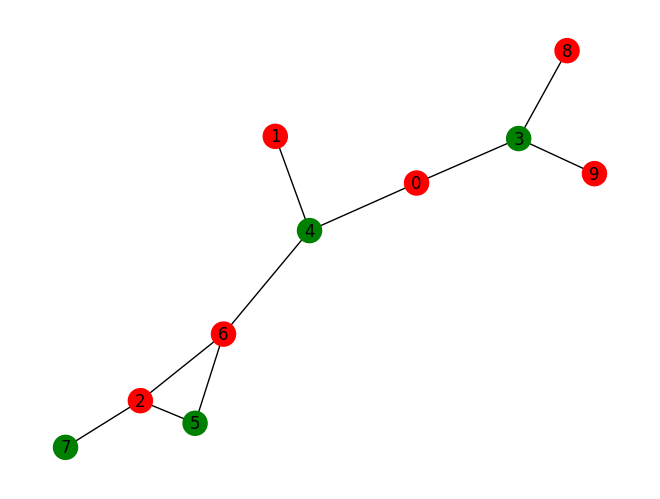

In [124]:
nodesa = [0, 1, 2, 6, 8, 9]
nodesb = [3, 4, 5, 7]
subset_color = ["red", "green"]

g = nx.Graph()
for n in rand_graph.nodes():
    if n in nodesa:
        g.add_node(node_for_adding=n, attr={'l': 0})
    else:
        g.add_node(node_for_adding=n, attr={'l': 1})
for a, b in rand_graph.edges:
    g.add_edge(a, b)

colors = [subset_color[data['attr']['l']] for v, data in g.nodes(data=True)]

nx.draw(g, node_color=colors, with_labels=True)